ECE 447: Root Locus Design
===

Prof. Eric Klavins

&copy; 2019, University of Washington

# Code

In [1]:
import numpy as np
import scipy.integrate as spi
import matplotlib.pyplot as plt
from sympy import *
from control import *

%matplotlib inline

# Comment out in Google colab 
init_printing(use_latex='mathjax')

# Uncomment in below Google colab to render sympy equations nicely
# def custom_latex_printer(exp,**options):
#     from google.colab.output._publish import javascript
#     url = "https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.3/latest.js?config=default"
#     javascript(url=url)
#     return printing.latex(exp,**options)
# init_printing(use_latex="mathjax",latex_printer=custom_latex_printer)

# Goal

The goal with root locus based design is to design a controller $G_c(s)$ to alter the shape of the root locus so that a gain $K$ can be chosen to give the desired performance. In the diagram below, the system with $KG(s)$ has marginally stable poles no matter what $K$ you choose. By adding a zero and remembering that the root locus goes from the poles to the zeros, we get as root locus for $KG_c(s)G(s)$ that can contains a variety of stable poles for different values of the gain $K$. 

<img width=55% src="https://raw.githubusercontent.com/klavins/ECE447/master/images/root-locus-design.png">

# Examples

Example: PI Control
---

A Proportional-Integral controller has the form

$$
G_c(s) = \frac{K_I}{s} + K_p
$$

which can be rewritten

$$
G_c(s) = \frac{K_p\left(s+\frac{K_I}{K_p}\right)}{s}
$$

Thus, PI control is adding a new pole at 0 and a new zero at $-\frac{K_I}{K_p}$. 

Example: PI Control of a Simple System
---

Suppose $G(s) = \frac{1}{s}$

<img width=55% src="https://raw.githubusercontent.com/klavins/ECE447/master/images/root-locus-pi.png">

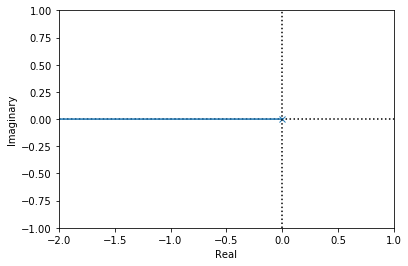

In [0]:
# Simple control: Only totally damped response possible
sys1 = tf([1],[1,0])
r,k = root_locus(sys1,xlim=(-2,1))

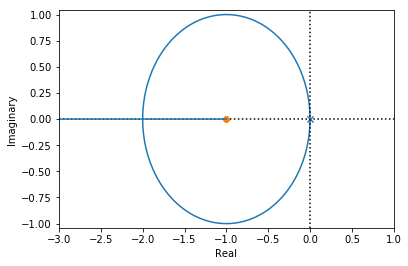

In [0]:
# PI control: A range of gains possible
z = -1
sys1 = tf([1,-z],[1,0,0])
r,k = root_locus(sys1,xlim=(-3,1))

Example: PID Control
---

A Proportional-Integral-Derivative controller has the form

$$
G_c(s) = K_p + K_D s + \frac{K_I}{s}
$$

which can be written

\begin{align}
G_c(s) & = \frac{K_D s^2 + K_p s + K_I}{s^2} \\
       & = K_d \frac{(p+z_1)(p+z_2)}{s^2}
\end{align}

Therefore, a PID controller amounts to picking two zero locations and placing to poles at zero. 

Example: PID Design
---

Suppose we wish to control the system

$$
G(s) = \frac{1}{s^2+2s+2}
$$

which has poles at $-1 \pm i$. Without a controller, the root locus looks like the following:

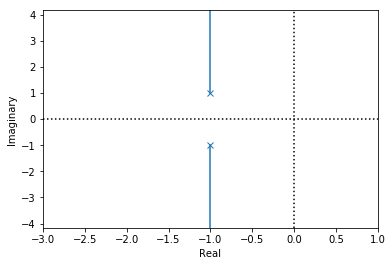

In [3]:
# Gain only, no controller
sys1 = tf([1],[1,2,2])
r,k = root_locus(sys1,xlim=(-3,1))

Now say we want the system to have a settling time of four seconds and a 10% overshoot. Then

$$
\zeta\omega = 4
$$

and

$$
\frac{\zeta\pi}{\beta} = - \ln (0.1)
$$

Solving the above gives:

In [4]:
var("s zeta omega")
sol=solve([zeta*omega-4, zeta*pi/sqrt(1-zeta**2)-log(0.1)])[0]
sol

{ω: -6.76641451278031, ζ: -0.591155033798898}

$$\left \{ \omega : -6.76641451278031, \quad \zeta : -0.591155033798898\right \}$$

Putting these values into

$$
s^2 + 2 \zeta \omega s + \omega^2
$$

and solving for $s$ gives us the desired denominator of $T(s):

In [5]:
den = (s**2 + 2*zeta*omega*s + omega**2).subs(sol)
den

 2                          
s  + 8.0⋅s + 45.784365358764

$$s^{2} + 8.0 s + 45.784365358764$$

That is, we want to place the poles of $T(s)$ at

In [35]:
den = (s**2 + 2*zeta*omega*s + omega**2).subs(sol)
poles = solve(den,s)
poles

[-4.0 - 5.45750541536735⋅ⅈ, -4.0 + 5.45750541536735⋅ⅈ]

$$\left [ -4.0 - 5.45750541536735 i, \quad -4.0 + 5.45750541536735 i\right ]$$


We can't place the poles anywhere, but we do know that as $K$ goes to $\infty$, the root locus goes to the zeros. So we can define a PID controller by

$$
K_D \frac{s^2 + 2 \zeta \omega s + \omega^2}{s}
$$

or in this case

In [14]:
Gc = den / s
Gc

 2                          
s  + 8.0⋅s + 45.784365358764
────────────────────────────
             s              

In [15]:
G = 1 / ( s**2 + 2*s + 2 )
GcG = Gc*G
GcG.cancel()

    ⎛     2                          ⎞
1.0⋅⎝1.0⋅s  + 8.0⋅s + 45.784365358764⎠
──────────────────────────────────────
            3        2                
       1.0⋅s  + 2.0⋅s  + 2.0⋅s        

$$\frac{1}{1.0 s^{5} + 4.0 s^{4} + 8.0 s^{3} + 8.0 s^{2} + 4.0 s} \left(1.0 K^{3} s^{2} + 8.0 K^{3} s + 45.784365358764 K^{3} + 1.0 K^{2} s^{3} + 2.0 K^{2} s^{2} + 2.0 K^{2} s + 1.0 K s^{2} + 2.0 K s + 2.0 K + 1.0 s^{5} + 4.0 s^{4} + 8.0 s^{3} + 8.0 s^{2} + 4.0 s\right)$$

In [18]:
var("K")
T = K * Gc * G / ( 1 + K * Gc * G)
T.cancel()
num,den=fraction(T)
solve(den.subs(K,0))

[0, -1 - ⅈ, -1 + ⅈ]

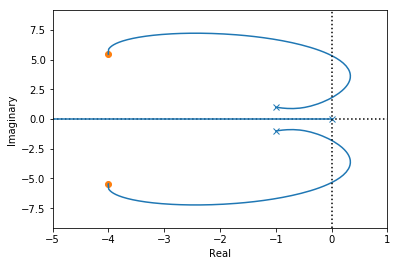

In [32]:
sys = tf([1,8,45.78],[1,2,2,0])
r,k=root_locus(sys,xlim=(-5,1))

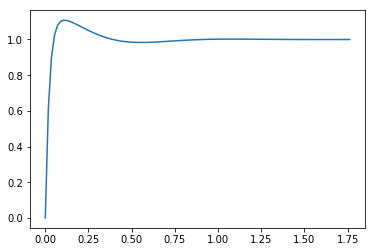

In [33]:
gain = tf([50],[1])
fb = feedback(series(sys,gain))
t,y = step_response(fb)
plt.plot(t,y);

# PID Control One Component at a Time

In [0]:
# Example Plant
G = (s+3) / ((s+1)*(s+2))
G.cancel()

   s + 3    
────────────
 2          
s  + 3⋅s + 2

In [0]:
# Proportional Control
Gc = 1
(Gc*G).cancel()

   s + 3    
────────────
 2          
s  + 3⋅s + 2

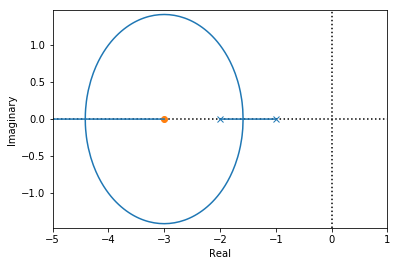

In [0]:
# Proportional Control Root Locus
# Good, but may not be able to get a desired percent overshoot
sys = tf([1,3],[1,3,2])
r,k=root_locus(sys,xlim=(-5,1))

In [0]:
# Derivative control
Gc = s
(Gc*G).cancel()

   2        
  s  + 3⋅s  
────────────
 2          
s  + 3⋅s + 2

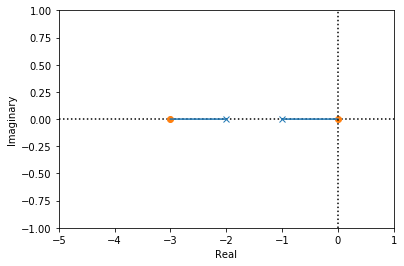

In [27]:
# Derivative Control Root Locus
# No way to get overshoot at all
sys = tf([1,3,0],[1,3,2])
r,k=root_locus(sys,xlim=(-5,1))

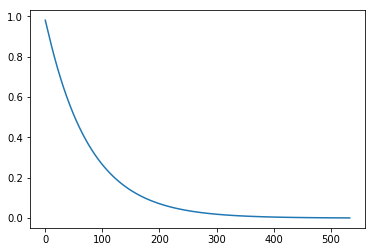

In [28]:
gain = tf([50],[1])
fb = feedback(series(sys,gain))
t,y = step_response(fb)
plt.plot(t,y);

In [0]:
# Integral control
Gc = 1/s
(Gc*G).cancel()

     s + 3     
───────────────
 3      2      
s  + 3⋅s  + 2⋅s

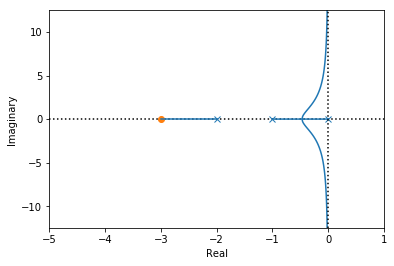

In [29]:
# Integral Control Root Locus
# R.L is too close to imaginary axis for comfort
sys = tf([1,3],[1,3,2,0])
r,k=root_locus(sys,xlim=(-5,1))

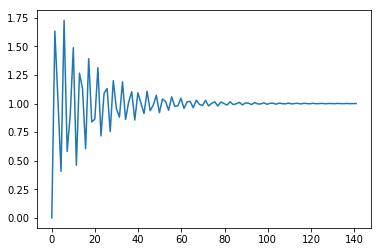

In [30]:
gain = tf([50],[1])
fb = feedback(series(sys,gain))
t,y = step_response(fb)
plt.plot(t,y);

In [0]:
# PID control
Gc = 10 + s + 26/s
(Gc*G).cancel()

 3       2            
s  + 13⋅s  + 56⋅s + 78
──────────────────────
    3      2          
   s  + 3⋅s  + 2⋅s    

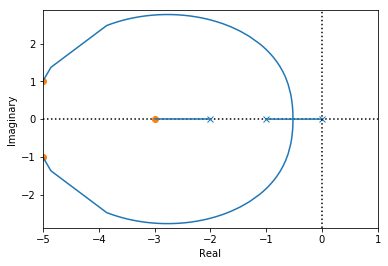

In [25]:
# PID Control Root Locus
# R.L in region with good percent overshoot
sys = tf([1,13,56,78],[1,3,2,0])
r,k=root_locus(sys,xlim=(-5,1))

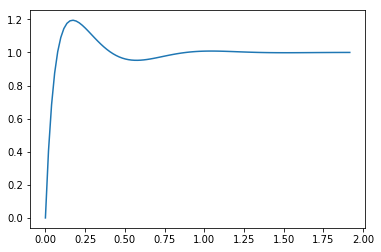

In [41]:
gain = tf([25],[1])
fb = feedback(series(sys,gain))
t,y = step_response(fb)
plt.plot(t,y);

# Don't cancel poles and zeros


Suppose that 

$$
G(s) = \frac{1}{s^2+1}
$$

which has poles at $\pm i$. To stabilize this system, you might be tempted to put

$$
K G_c(s) = K \frac{s^2+1}{s}
$$

so that

$$
K Gc(s) G(s) = \frac{K}{s}.
$$

This system looks great since you can get any negative real pole you want along the root locus.

However, because $G(s)$ is just a model and possibly inaccurate, you probably would get a root locus more like the following, which is not very stable or even possibly unstable.

In [0]:
G = 1 / ( s**2 - 0.1*s + 1.1) # what you might actually get instead of 
                              # 1 / ( s**2 + 1 )
Gc = (s**2 + 1)/s
Gc*G

        2           
       s  + 1       
────────────────────
  ⎛ 2              ⎞
s⋅⎝s  - 0.1⋅s + 1.1⎠

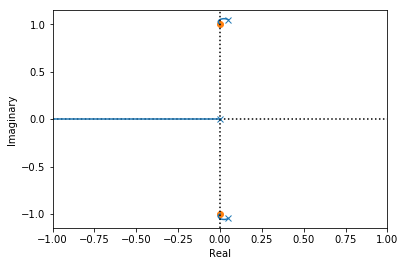

In [0]:
sys = tf([1,0,1],[1,-0.1,1.1,0])
r,k=root_locus(sys,xlim=(-1,1))